In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [0]:
import os
files = os.listdir("/content/gdrive/My Drive/Proyecto Simulación/EXPERIMENTOS/resized_train/resized_train")
print(len(files))

35134


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def modificar_imagen_1(imagen):
  dpi = 80 #inch
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  target_size = (512,512)
  imagen = cv2.resize(imagen,target_size)
  height, width = imagen.shape
  SCALE=2
  figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE
  fig = plt.figure(figsize=figsize)
  plt.imshow(imagen, cmap='gray')
  return imagen
  


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

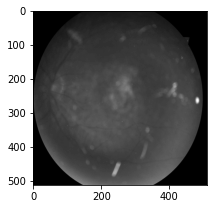

In [0]:
image_test = cv2.imread('/content/gdrive/My Drive/Proyecto Simulación/EXPERIMENTOS/1/resized_train/44268_left.jpeg')
modificar_imagen_1(image_test)

In [0]:
IMG_SIZE = 512

In [0]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [0]:
def modificar_imagen_2(ruta_imagen):
  dpi = 80 #inch
  image = load_ben_color(ruta_imagen,sigmaX=10)
  target_size = (512,512)
  image = cv2.resize(image, target_size)
  #height, width = IMG_SIZE, IMG_SIZE
  #print(height, width)
  #SCALE=1
  #figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE
  #fig = plt.figure(figsize=figsize)
  #plt.imshow(image, cmap='gray')
  return image

In [0]:
print(modificar_imagen_2('/content/gdrive/My Drive/Proyecto Simulación/EXPERIMENTOS/1/resized_train/44268_left.jpeg').shape)

(512, 512, 3)


In [0]:
def extraer_caracteristicas(imagen):
  surf  = cv2.xfeatures2d.SURF_create(5000)
  #calculate keypoints and their orientation
  keypoints = surf.detectAndCompute(imagen,None)[1]
  try:
    to_reshape=keypoints.shape[0]*keypoints.shape[1]
  except:
    print("Error")
    return []
  return keypoints.reshape(to_reshape)


In [0]:
imagen = modificar_imagen_2('/content/gdrive/My Drive/Proyecto Simulación/EXPERIMENTOS/1/resized_train/44268_left.jpeg')
print(len(extraer_caracteristicas(imagen=imagen)))

2560


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [0]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
#from PIL import Image, ImageOps2322
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 

Using TensorFlow backend.


In [0]:
df_train = pd.read_csv('/content/2trainLabels_cropped')
#df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

x = df_train['image']
y = df_train['level']

x, y = shuffle(x, y, random_state=SEED)

In [0]:
y

9859     2.0
10584    2.0
1879     0.0
5240     1.0
2792     0.0
        ... 
9509     2.0
2283     0.0
10196    2.0
11860    2.0
8799     2.0
Name: level, Length: 14108, dtype: float64

(11991,) (11991,) (2117,) (2117,)


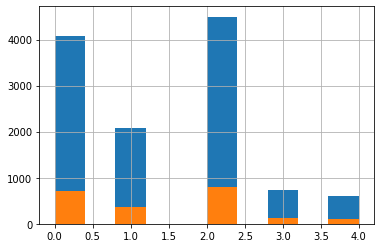

In [0]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

In [0]:
df_train.set_index(['image','level'],inplace=True)

In [0]:
for i in df_train.index:
  print(i)

Se han truncado las últimas 5000 líneas del flujo de salida.
('14992_right', 2.0)
('15000_right', 2.0)
('15023_right', 2.0)
('15034_left', 2.0)
('15034_right', 2.0)
('15056_right', 2.0)
('15066_right', 2.0)
('15074_left', 2.0)
('15074_right', 2.0)
('15080_left', 2.0)
('15083_left', 2.0)
('15095_left', 2.0)
('15114_right', 2.0)
('15117_left', 2.0)
('15117_right', 2.0)
('15120_left', 2.0)
('15120_right', 2.0)
('15138_left', 2.0)
('15138_right', 2.0)
('15154_left', 2.0)
('15154_right', 2.0)
('15185_left', 2.0)
('15185_right', 2.0)
('15193_left', 2.0)
('15193_right', 2.0)
('15222_right', 2.0)
('15225_right', 2.0)
('15257_right', 2.0)
('15273_left', 2.0)
('15273_right', 2.0)
('15274_right', 2.0)
('15276_left', 2.0)
('15276_right', 2.0)
('15278_left', 2.0)
('15278_right', 2.0)
('15297_left', 2.0)
('15297_right', 2.0)
('15302_left', 2.0)
('15302_right', 2.0)
('15309_left', 2.0)
('15309_right', 2.0)
('15351_right', 2.0)
('15354_left', 2.0)
('15354_right', 2.0)
('15375_right', 2.0)
('15385_left

In [0]:
array_X = []
array_Y = []

for i in df_train.index:
  j = 0
  path=f"/content/gdrive/My Drive/Proyecto Simulación/EXPERIMENTOS/1/resized_train/{i[0]}.jpeg"
  image = cv2.imread(path)
  image = modificar_imagen_2(ruta_imagen=path)
  caracteristicas = extraer_caracteristicas(image)
  if len(caracteristicas) >= 150:
      array_X.append(caracteristicas[0:150])
      array_Y.append(i[1])
  print(i[1])

Se han truncado las últimas 5000 líneas del flujo de salida.
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
Error
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
Error
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
Error
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2

In [0]:
Y = np.asarray(array_Y)

In [0]:
X.shape

(13493, 150)

In [0]:
Y.shape

(13493,)

In [0]:
dataframe = pd.DataFrame(Y)

In [0]:
dataframe.to_csv("Y_labels")